# Dim 3 point 

Compare random seeds

In [1]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

In [3]:
import sys
sys.path.append('../../modules/')

In [4]:
%reload_ext autoreload
%autoreload 2
import datasets
import ML_classes
import evaluation

2025-02-10 21:31:23.024936: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-10 21:31:23.047230: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-10 21:31:23.053246: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Setup experiment

In [14]:
# We need one place to save all the experiment relevant info.  
experiment_config= {'simulation_names':['DG'], 
                    'filter_scales':['50','100','200','400'],
                    #'filter_scales':['100'],
                    'window_size':3, 
                    'all_ml_variables' : ['dudx_widened_rotated_nondim',  # must include all variables, including those used as coefficients
                                          'dvdx_widened_rotated_nondim', 
                                          'dudy_widened_rotated_nondim',
                                          'dvdy_widened_rotated_nondim',
                                          'dhdx_widened_rotated_nondim',
                                          'dhdy_widened_rotated_nondim',
                                          'mag_nabla_h_widened',
                                          'filter_scale', 
                                          'mag_nabla_u_widened',
                                          'uphp_rotated',  # this non-dim has taken a particular form (see in paper, flux/L^2/|grad u|)
                                          'vphp_rotated',
                                          'uphp_rotated_nondim',  # this non-dim has taken a particular form (see in paper, flux/L^2/|grad u|)
                                          'vphp_rotated_nondim'], 
                    
                    'input_channels' :   ['dudx_widened_rotated_nondim',  
                                          'dvdx_widened_rotated_nondim', 
                                          'dudy_widened_rotated_nondim',
                                          'dvdy_widened_rotated_nondim',
                                          'dhdx_widened_rotated_nondim',
                                          'dhdy_widened_rotated_nondim'],
                    
                    'output_channels' :  ['uphp_rotated',
                                          'vphp_rotated'],
                    
                    'coeff_channels'  : ['filter_scale','filter_scale','mag_nabla_h_widened', 'mag_nabla_u_widened'], 

                    'extra_channels'   : [],

                    'use_coeff_channels': True,

                    'all_time_range': slice(200, -1),
                    'train_time_range': slice(0, 2048),
                    'test_time_range' : slice(-128, None),
                    'eval_time_range' : slice(-256, -128),
                    'num_train_batches': 128, 
                    'num_test_batches' : 8, 

                    #'num_inputs': 55, 
                    'network_shape': [36, 36, 2],

                    'exp_ckpt_save_dir': '/home/jovyan/mesoscale_buoyancy_param_ML/ML_checkpoints/evaluate_model_design/impact_random_seeds/window_3/'
                    
            }
experiment_config['num_inputs'] = len(experiment_config['input_channels']) * experiment_config['window_size']**2

## SimulationData Module
#### Load data for different simulations and prepare it with right variables and non-dims.

In this step all the variables and extra dimensions may be created that were not originally present. 
Each input and output variable gets its own containing variable (e.g. if top and bottom layer were two separate inputs, then in this step they may get separated out). 
Other examples might be that rotated variables, or magnitudes become their own variables in this step. 

In [6]:
#DT = datasets.SimulationData(simulation_names=['P2L', 'DG'], filter_scales=['50','100','200','400'])
DT = datasets.SimulationData(simulation_names=experiment_config['simulation_names'], 
                             filter_scales=experiment_config['filter_scales'], 
                             window_size = experiment_config['window_size'], 
                             time_sel = experiment_config['all_time_range'],
                             single_layer_mask_flag=True
                             )

In [7]:
DT.simulation_data['DG']['100']

DataTree('100', parent="DG")
    Dimensions:                      (Time: 3399, xh: 100, yh: 108, zl: 2, Xn: 3,
                                      Yn: 3, zi: 3)
    Coordinates:
      * Time                         (Time) object 27kB 0006-07-04 00:00:00 ... 0...
      * xh                           (xh) float64 800B 0.11 0.33 ... 21.67 21.89
      * yh                           (yh) float64 864B 30.27 30.45 ... 49.55 49.73
      * zl                           (zl) float64 16B 1.035e+03 1.036e+03
      * zi                           (zi) float64 24B 1.034e+03 1.036e+03 1.037e+03
    Dimensions without coordinates: Xn, Yn
    Data variables: (12/67)
        dudx_widened                 (Time, zl, yh, xh, Xn, Yn) float64 5GB dask.array<chunksize=(16, 2, 107, 99, 3, 3), meta=np.ndarray>
        dvdx_widened                 (Time, zl, yh, xh, Xn, Yn) float64 5GB dask.array<chunksize=(16, 2, 107, 99, 3, 3), meta=np.ndarray>
        dudy_widened                 (Time, zl, yh, xh, Xn, Yn) float64 5GB dask.array<chunksize=(16, 2, 107, 99, 3, 3), meta=np.ndarray>
        dvdy_widened                 (Time, zl, yh, xh, Xn, Yn) float64 5GB dask.array<chunksize=(16, 2, 107, 99, 3, 3), meta=np.ndarray>
        dhdx_widened                 (Time, zl, yh, xh, Xn, Yn) float64 5GB dask.array<chunksize=(16, 2, 107, 99, 3, 3), meta=np.ndarray>
        dhdy_widened                 (Time, zl, yh, xh, Xn, Yn) float64 5GB dask.array<chunksize=(16, 2, 107, 99, 3, 3), meta=np.ndarray>
        ...                           ...
        uphp_rotated_nondim          (Time, zl, yh, xh) float64 587MB dask.array<chunksize=(16, 2, 107, 99), meta=np.ndarray>
        vphp_rotated_nondim          (Time, zl, yh, xh) float64 587MB dask.array<chunksize=(16, 2, 107, 99), meta=np.ndarray>
        uphp_nondim                  (Time, zl, yh, xh) float64 587MB dask.array<chunksize=(16, 2, 107, 99), meta=np.ndarray>
        vphp_nondim                  (Time, zl, yh, xh) float64 587MB dask.array<chunksize=(16, 2, 107, 99), meta=np.ndarray>
        Rd_nondim                    (Time, yh, xh) float64 294MB dask.array<chunksize=(16, 108, 100), meta=np.ndarray>
        single_layer_mask            (Time, yh, xh) float64 294MB dask.array<chunksize=(16, 108, 100), meta=np.ndarray>
    Attributes:
        simulation_name:  DG
        filter_scale:     100
        source:           gs://leap-persistent/dhruvbalwada/MOM6/Double_Gyre/res5...
        description:      Dataset for DG experiment at 100 km resolution

## MLXarrayDataset 

Go from simulation data to batchesm but still as Xarray objects. 
In this step things like dropping extra points, masking of data etc happen. 

In [8]:
ML_DT_train = datasets.MLXarrayDataset(simulation_data=DT, 
                                       all_ml_variables=experiment_config['all_ml_variables'],
                                       time_range=experiment_config['train_time_range'],
                                       num_batches = experiment_config['num_train_batches'])

Will load : 5.7851904 gb into memory.
load took: 160.9918 seconds


In [9]:
ML_DT_test = datasets.MLXarrayDataset(simulation_data=DT,
                                      all_ml_variables=experiment_config['all_ml_variables'],
                                      time_range=experiment_config['test_time_range'],
                                      num_batches = experiment_config['num_test_batches'])

Will load : 0.3615744 gb into memory.
load took: 12.0751 seconds


## MLJAXDataset 

### Convert these xbatcher batches to processed ones for training

This needs to take care of extra dims, like Xn,Yn.

In [10]:
train_ML_data = datasets.MLJAXDataset(ML_DT_train, 
                                      input_channels=experiment_config['input_channels'], 
                                      output_channels=experiment_config['output_channels'], 
                                      coeff_channels=experiment_config['coeff_channels'], 
                                      use_coeff_channels=experiment_config['use_coeff_channels'],
                                      do_normalize=True)

In [11]:
test_ML_data = datasets.MLJAXDataset(ML_DT_test, 
                                      input_channels=experiment_config['input_channels'], 
                                      output_channels=experiment_config['output_channels'], 
                                      coeff_channels=experiment_config['coeff_channels'],
                                      use_coeff_channels=experiment_config['use_coeff_channels'],
                                      do_normalize=True)

In [12]:
ML_data_combo = {'train_data':train_ML_data, 'test_data':test_ML_data}

In [13]:
for batch_out in ML_data_combo['train_data'].get_batches():
    print("Input (X) batch shape:", batch_out['X'].shape)
    print("Input (Xp) batch shape:", batch_out['Xp'].shape)
    print("Output (y) batch shape:", batch_out['y'].shape)
    
    # If you want to view a sample of the data
    #print("Sample X:", batch_out['X'])  # First sample of the batch
    #print("Sample y:", batch_out['y'])  # Corresponding label/target
    break  # Remove break to print more batches

Input (X) batch shape: (49753, 54)
Input (Xp) batch shape: (49753, 1)
Output (y) batch shape: (49753, 2)


## AnnRegressionSystem (and associated NN setup modules ArtificialNeuralNetwork and PointwiseANN).


In [16]:
random_seed_sets = {'model0': {'random_seed':0},
                      'model1': {'random_seed':1},
                      'model2': {'random_seed':2},
                      'model3': {'random_seed':3},
                      'model4': {'random_seed':4},
                      'model5': {'random_seed':5}
                     }
                      

In [ ]:
for random_key in random_seed_sets.keys():
    #ML_data_combo = {'train_data':train_sets[train_keys]['train_ML_data'], 'test_data':test_ML_data}
    
    ANN_model = ML_classes.PointwiseANN(num_in = experiment_config['num_inputs'],
                                        shape = experiment_config['network_shape'],
                                        random_key = random_seed_sets[random_key]['random_seed']) 
    #networks[model_key]['num_params'] = ANN_model.count_parameters()
    regress_sys = ML_classes.AnnRegressionSystem(ANN_model, loss_type='mae')

    print('Start training: ', random_key)
    regress_sys.train_system(ML_data_combo, num_epoch=501, print_freq=20, min_relative_improvement=1e-2)
    
    random_seed_sets[random_key]['regress_sys'] = regress_sys

    random_seed_sets[random_key]['save_dir'] = experiment_config['exp_ckpt_save_dir'] + random_key

    regress_sys.save_checkpoint(random_seed_sets[random_key]['save_dir'])

Start training:  model0
At epoch 1. Train loss :  1.2390402611345053 , Test loss: 1.0309304147958755 , Test R2: 0.517266035079956
At epoch 21. Train loss :  0.7901250962167978 , Test loss: 0.7891090959310532 , Test R2: 0.6999817118048668
At epoch 41. Train loss :  0.7651377012953162 , Test loss: 0.7638163268566132 , Test R2: 0.7171084582805634
At epoch 61. Train loss :  0.752302760258317 , Test loss: 0.7501418516039848 , Test R2: 0.7251264080405235
Early stopping at epoch 62. No improvement in 10 epochs.
Restored best model with smoothed test loss 0.755077
Start training:  model1
At epoch 1. Train loss :  1.2231631763279438 , Test loss: 1.0245314091444016 , Test R2: 0.51558718085289
At epoch 21. Train loss :  0.797784605063498 , Test loss: 0.7975730746984482 , Test R2: 0.6916493326425552


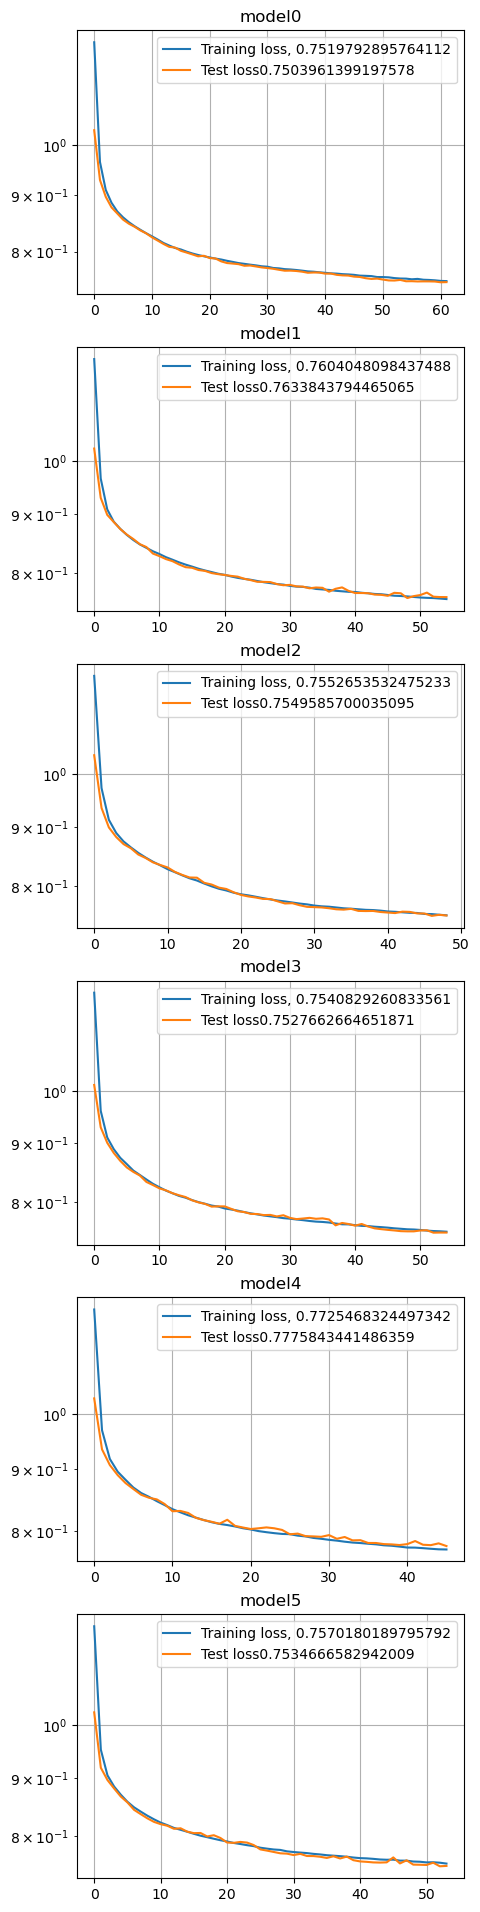

In [25]:
## Loss plot
num_models = len(random_seed_sets.keys())

fig = plt.figure(figsize=(5, 4*num_models))  

for i, random_keys in enumerate(random_seed_sets.keys()):
    regress_sys = random_seed_sets[random_keys]['regress_sys'] 
    plt.subplot(num_models, 1, i+1)
    plt.plot(regress_sys.train_loss, label='Training loss, '+str(regress_sys.train_loss[-1]))
    plt.plot(regress_sys.test_loss, label='Test loss'+str(regress_sys.test_loss[-1]))

    plt.grid()
    plt.yscale('log')
    plt.title(random_keys)
    plt.legend()

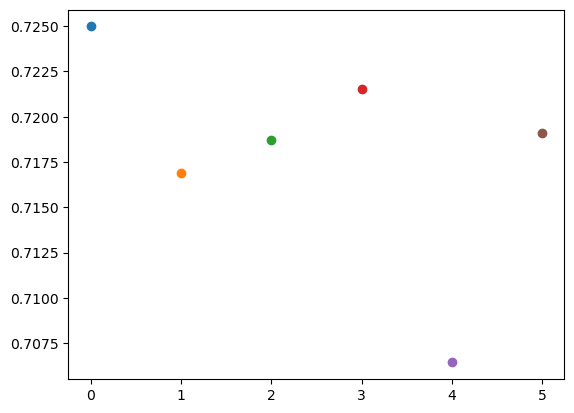

In [26]:
for random_keys in random_seed_sets.keys():
    plt.plot(random_seed_sets[random_keys]['random_seed'], 
             random_seed_sets[random_keys]['regress_sys'].test_R2[-1], 'o')
#plt.xscale('log')


This range of variation is quite similar to the very small impact of learning rate. Much smaller compared to impact of datasize or model size.